# Carteira Recomendada utilizando Yahoo Finance

In [375]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# Dados
## Lista de ações
Para iniciar a construção do modelo responsável pela **recomendação da carteira de investimentos**, é necessário selecionar as **ações que serão o foco do estudo** durante o processo de definição dessa recomendação.

In [157]:
# tickers = ["ITSA4.SA", "ITUB4.SA","WEGE3.SA","PETR3.SA","AZUL4.SA", "B3SA3.SA","VALE3.SA","ABEV3.SA", "ALPA4.SA","BBAS3.SA","SUZB3.SA"]

tickers = [
    "ABEV3.SA", "ALPA4.SA", "AMER3.SA", "ASAI3.SA", "AZUL4.SA", "B3SA3.SA",
    "BBAS3.SA", "BBDC3.SA", "BBDC4.SA", "BBSE3.SA", "BPAC11.SA", "BRAP4.SA",
    "BRFS3.SA", "BRKM5.SA", "BRML3.SA", "CASH3.SA", "CCRO3.SA", "CIEL3.SA",
    "CMIG4.SA", "COGN3.SA", "CPFE3.SA", "CPLE6.SA", "CRFB3.SA", "CSAN3.SA",
    "CSNA3.SA", "CYRE3.SA", "DXCO3.SA", "ELET3.SA", "ELET6.SA", "EMBR3.SA",
    "ENGI11.SA", "EQTL3.SA", "EZTC3.SA", "GGBR4.SA", "GOAU4.SA", "GOLL4.SA",
    "HAPV3.SA", "HYPE3.SA", "IGTI11.SA", "ITSA4.SA", "ITUB4.SA", "JBSS3.SA",
    "KLBN11.SA", "LREN3.SA", "MGLU3.SA", "MRFG3.SA", "MRVE3.SA", "MULT3.SA",
    "NTCO3.SA", "PETR3.SA", "PETR4.SA", "PRIO3.SA", "RADL3.SA", "RAIL3.SA",
    "RENT3.SA", "RRRP3.SA", "SANB11.SA", "SBSP3.SA", "SMTO3.SA", "SOMA3.SA",
    "SUZB3.SA", "TAEE11.SA", "TIMS3.SA", "UGPA3.SA", "USIM5.SA", "VALE3.SA",
    "VBBR3.SA", "VIIA3.SA", "VIVT3.SA", "WEGE3.SA", "YDUQ3.SA"
]

reference_index = "^BVSP"

### Coleta dos dados
Os dados utilizados neste estudo foram obtidos por meio da **API do Yahoo Finance**, que disponibiliza informações históricas sobre o desempenho de ações negociadas no mercado financeiro.  
A extração foi realizada para o período previamente definido, considerando as ações selecionadas para análise.

A API fornece, para cada ativo, as seguintes variáveis:

- **Open** – preço de abertura da ação no respectivo dia de negociação.  
- **High** – preço máximo atingido pela ação no período considerado.  
- **Low** – preço mínimo registrado no período.  
- **Close** – preço de fechamento da ação.  
- **Volume** – quantidade total de ações negociadas no período.

Esses dados constituem a base de entrada para as etapas subsequentes de processamento, análise e modelagem.

In [174]:
raw_data = yf.download(tickers, start="2024-01-01", end="2025-10-01")
reference_index_data = yf.download(reference_index, start="2024-01-01", end="2025-10-01")

print(raw_data.head())
print(reference_index_data.head())

C:\Users\airto\AppData\Local\Temp\ipykernel_37448\1889707196.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start="2024-01-01", end="2025-10-01")
[*********************100%***********************]  59 of 59 completed
C:\Users\airto\AppData\Local\Temp\ipykernel_37448\1889707196.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  reference_index_data = yf.download(reference_index, start="2024-01-01", end="2025-10-01")
[*********************100%***********************]  1 of 1 completed

Price           Close                                                    \
Ticker       ABEV3.SA  ALPA4.SA AMER3.SA   ASAI3.SA AZUL4.SA   B3SA3.SA   
Date                                                                      
2024-01-02  12.496864  9.157123     90.0  12.787717    14.70  13.492297   
2024-01-03  12.396598  9.432525     90.0  12.709144    14.21  13.454209   
2024-01-04  12.442174  8.822705     88.0  12.974327    13.84  13.063819   
2024-01-05  12.396598  9.225972     87.0  13.337727    13.83  13.301864   
2024-01-08  12.496864  9.530882     87.0  13.917200    14.89  13.597035   

Price                                                   ...   Volume  \
Ticker       BBAS3.SA   BBDC3.SA   BBDC4.SA   BBSE3.SA  ... SUZB3.SA   
Date                                                    ...            
2024-01-02  24.227684  12.916666  14.373685  27.975716  ...  2961200   
2024-01-03  24.249807  12.922871  14.389986  27.851894  ...  3343500   
2024-01-04  23.993193  12.751707  14.19

### Limpeza dos dados
Com base nos dados obtidos da API, realizamos a **limpeza dos ativos** que não tiveram as informações necessárias disponíveis ou que apresentaram **dados faltantes**.

In [175]:
tickers_to_remove = [
    t for t in raw_data.columns.get_level_values(1).unique()
    if raw_data.xs(t, axis=1, level=1).isnull().any().any()
]

data = raw_data.drop(columns=tickers_to_remove, level=1)
tickers = [t for t in tickers if t not in tickers_to_remove]

print("Tickers removidos:", tickers_to_remove)

Tickers removidos: []


### Visualização dos dados
Com os dados revisados, é possível gerar uma **visualização gráfica** do valor das ações selecionadas ao longo do período definido para o estudo.  
Essa visualização permite observar como os preços das ações **variam ao longo do tempo**, refletindo os fenômenos do mercado nacional e internacional.

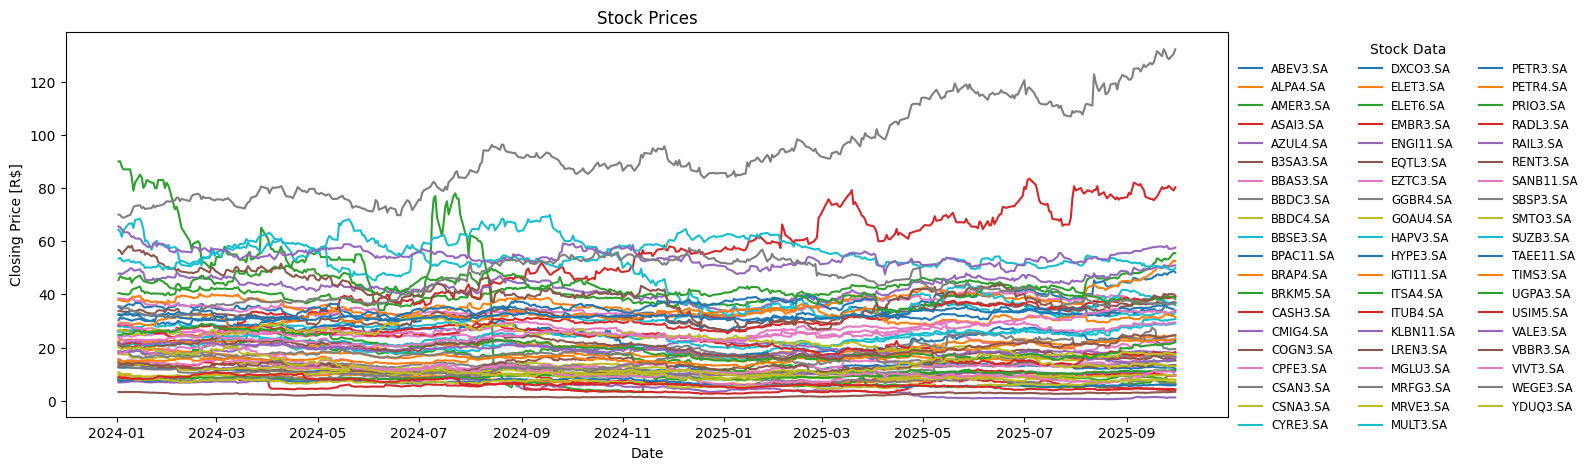

In [160]:
plt.figure(figsize=(15,5))

for ticker in tickers:
    plt.plot(data.index, data["Close", ticker], label=ticker)

plt.xlabel("Date")
plt.ylabel("Closing Price [R$]")
plt.title("Stock Prices")
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize='small',
    frameon=False,
    ncol=3,
    title='Stock Data'
)
plt.show()

### Cálculo das métricas (feature engineering)
Com os dados fornecidos pela API, realizamos a **extração das métricas** que caracterizam a performance de cada ativo no mercado de capitais. Foram consideradas métricas essenciais para a análise de ações, permitindo avaliar tanto o retorno quanto o risco associado a cada ativo ao longo do período analisado:

- **Retorno acumulado** – compara o preço de fechamento do último dia com o do primeiro, medindo o **ganho ou perda do ativo** no horizonte temporal considerado.  
- **Volatilidade** – representa o **desvio padrão dos retornos diários** ao longo do período. Quanto maior a volatilidade, **maior o risco associado** ao ativo.  
- **Drawdown** – mede a **maior queda do preço em relação a um pico anterior** dentro do período analisado, indicando a **exposição máxima a perdas**.  
- **Volume médio** – calcula a **média diária de negociação do ativo**, fornecendo uma noção da **liquidez do mercado**.  
- **Índice de correlação com referência** – avalia a **relação do desempenho da ação com um índice de mercado de referência**, permitindo identificar **quanto o ativo se movimenta em conjunto com o mercado**.  
- **Sharpe ratio** – combina retorno e risco ao dividir o **retorno acumulado pelo desvio padrão dos retornos diários**, fornecendo uma medida de **retorno ajustado pelo risco**.

In [190]:
keys = ["ticker","cumulative_return_period","return_std_deviation","volume_avg","drawdown","sharpe_ratio","correlation_index"]
metrics = {key: [] for key in keys}

reference_index_return = reference_index_data[('Close', reference_index)].pct_change().dropna()
reference_index_return = reference_index_return.reset_index(drop=True)

for ticker in tickers:
    close_values = data[('Close', ticker)]
    close_values = close_values.reset_index(drop=True)
    volume = data[('Volume', ticker)]

    cumulative_return_period = (close_values.iloc[-1] / close_values.iloc[0]) - 1
    daily_return = close_values.pct_change().dropna()
    return_std_deviation = daily_return.std()
    volume_avg = volume.mean()
    drawdown = (close_values/close_values.cummax()-1).min()
    sharpe_ratio = cumulative_return_period / return_std_deviation if return_std_deviation > 0 else 0
    correlation_index = daily_return.corr(reference_index_return)

    metrics["ticker"].append(ticker)
    metrics["cumulative_return_period"].append(cumulative_return_period)
    metrics["return_std_deviation"].append(return_std_deviation)
    metrics["volume_avg"].append(volume_avg)
    metrics["drawdown"].append(drawdown)
    metrics["sharpe_ratio"].append(sharpe_ratio)
    metrics["correlation_index"].append(correlation_index)

df = pd.DataFrame(metrics)
print(df)

       ticker  cumulative_return_period  return_std_deviation    volume_avg  \
0    ABEV3.SA                 -0.032557              0.013219  3.006245e+07   
1    ALPA4.SA                  0.028707              0.023256  2.939986e+06   
2    AMER3.SA                 -0.932111              0.109600  2.644121e+06   
3    ASAI3.SA                 -0.256318              0.027527  1.617411e+07   
4    AZUL4.SA                 -0.918367              0.053721  2.787388e+07   
5    B3SA3.SA                 -0.006841              0.019589  4.272655e+07   
6    BBAS3.SA                 -0.088233              0.014410  2.256565e+07   
7    BBDC3.SA                  0.177735              0.016358  7.914990e+06   
8    BBDC4.SA                  0.229378              0.017864  3.726989e+07   
9    BBSE3.SA                  0.188888              0.010737  5.070855e+06   
10  BPAC11.SA                  0.359903              0.017709  8.658376e+06   
11   BRAP4.SA                 -0.208361             

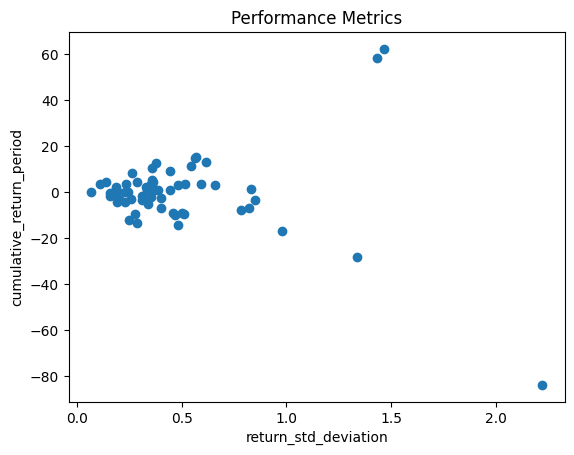

In [143]:
plt.scatter(df["return_std_deviation"],df["cumulative_return_period"])
plt.xlabel("return_std_deviation")
plt.ylabel("cumulative_return_period")
plt.title("Performance Metrics")
plt.show()

In [137]:
X = df[["cumulative_return_period", "return_std_deviation"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [138]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [139]:
cluster_stats = df.groupby('cluster')[["cumulative_return_period", "return_std_deviation"]].mean()
cluster_stats['score'] = cluster_stats["cumulative_return_period"] / cluster_stats["return_std_deviation"]

print("Desempenho médio por cluster:")
print(cluster_stats)

Desempenho médio por cluster:
         cumulative_return_period  return_std_deviation      score
cluster                                                           
0                       60.232761              1.450408  41.528151
1                       -0.893026              0.409648  -2.179984
2                      -83.890000              2.222188 -37.751076


In [140]:
best_cluster = cluster_stats['score'].idxmax()
df['recomendado'] = df['cluster'] == best_cluster

print("\nAções recomendadas:")
print(df[df['recomendado']][['ticker', "cumulative_return_period", "return_std_deviation"]])


Ações recomendadas:
      ticker  cumulative_return_period  return_std_deviation
23  EMBR3.SA                 58.292633              1.433319
47  SBSP3.SA                 62.172890              1.467497


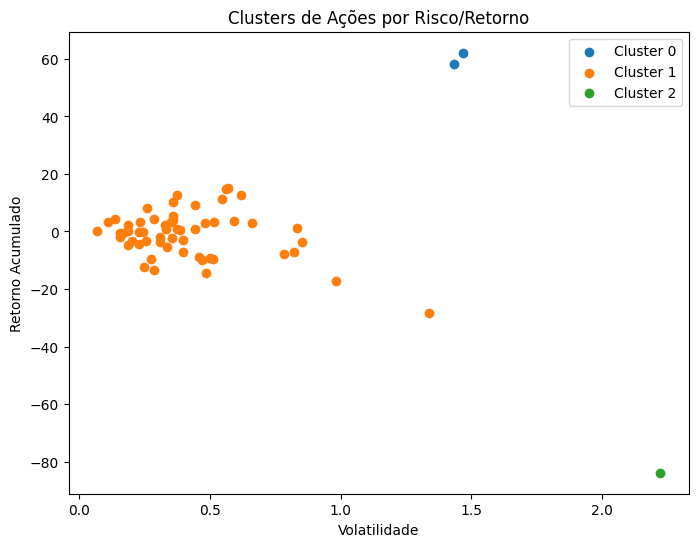

In [141]:
plt.figure(figsize=(8,6))
for c in range(k):
    subset = df[df['cluster'] == c]
    plt.scatter(subset["return_std_deviation"], subset["cumulative_return_period"], label=f'Cluster {c}')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno Acumulado')
plt.title('Clusters de Ações por Risco/Retorno')
plt.legend()
plt.show()

In [ ]:
# X = df[["cumulative_return_period","return_std_deviation","drawdown","volume_avg","correlation_index","sharpe_ratio"]]
# y = df["score"]

X = df[["cumulative_return_period","return_std_deviation","drawdown","volume_avg","correlation_index"]]
y = df["sharpe_ratio"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)

In [413]:
param_grid = {
    'n_estimators': [100,200,300,400,500],
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.05,0.1],
    'subsample': [0.7,0.8,1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled, y)
optimized_parameters = grid_search.best_params_
print(optimized_parameters)

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}


In [414]:
modelo = XGBRegressor(
    **optimized_parameters,
    colsample_bytree=0.9,
    random_state=42
)
modelo.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [416]:
y_pred = modelo.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R²: 0.740
RMSE: 15.0254


In [417]:
df["score_predito"] = modelo.predict(X_scaled)
df = df.sort_values(by=["score_predito","ticker"], ascending=[False,True]).reset_index(drop=True)
df_recomendadas = df.head(5)  # top 5 ações recomendadas

print("\n📈 Ações recomendadas:")
print(df_recomendadas[["ticker","cumulative_return_period","return_std_deviation","drawdown","score_predito"]])


📈 Ações recomendadas:
     ticker  cumulative_return_period  return_std_deviation  drawdown  \
0  SBSP3.SA                  0.888221              0.015385 -0.136778   
1  EMBR3.SA                  2.649982              0.026227 -0.243158   
2  MRFG3.SA                  1.348357              0.031815 -0.298692   
3  CMIG4.SA                  0.635798              0.014979 -0.142795   
4  ITUB4.SA                  0.474780              0.012325 -0.189040   

   score_predito  
0      57.716480  
1      42.511940  
2      42.389423  
3      39.955345  
4      38.520821  
